In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, roc_curve, accuracy_score, f1_score, recall_score, mean_squared_error, mean_absolute_error, r2_score, precision_score
from pathlib import Path
from imblearn.over_sampling import SMOTE
from joblib import dump


In [2]:
PROJECT_ROOT = Path().resolve().parent
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"
ART_DIR = PROJECT_ROOT / "reports" / "artifacts"
ART_DIR.mkdir(parents=True, exist_ok=True)

df_status = pd.read_csv("../data/processed/clinicaltrials_features_status.csv")
df_duration = pd.read_csv("../data/processed/clinicaltrials_features_duration.csv")
df = df_status.copy() 
df.shape
df.head()




,NCTId,OverallStatus_COMPLETED,OverallStatus_ENROLLING_BY_INVITATION,OverallStatus_NOT_YET_RECRUITING,OverallStatus_RECRUITING,OverallStatus_SUSPENDED,OverallStatus_TERMINATED,OverallStatus_UNKNOWN,OverallStatus_WITHDRAWN,PrimaryConditionMesh,...,PrimaryCountry_reduced_China,PrimaryCountry_reduced_Egypt,PrimaryCountry_reduced_France,PrimaryCountry_reduced_Germany,PrimaryCountry_reduced_Japan,PrimaryCountry_reduced_Other,PrimaryCountry_reduced_South Korea,PrimaryCountry_reduced_United Kingdom,PrimaryCountry_reduced_United States,PrimaryCountry_reduced_Unknown
0,NCT01315821,False,False,False,False,False,False,True,False,"Enterocolitis, Necrotizing",...,False,False,False,False,False,True,False,False,False,False
1,NCT04551521,True,False,False,False,False,False,False,False,Neoplasm Metastasis,...,False,False,False,True,False,False,False,False,False,False
2,NCT04086121,False,False,False,False,False,True,False,False,"Dermatitis, Atopic",...,False,False,False,False,False,False,False,False,True,False
3,NCT01181921,False,False,False,False,False,True,False,False,Alzheimer Disease,...,False,False,False,False,False,True,False,False,False,False
4,NCT05435014,False,False,False,True,False,False,False,False,"Carcinoma, Hepatocellular",...,False,False,False,False,False,True,False,False,False,False


In [3]:
df["target"] = np.nan

df.loc[df["OverallStatus_COMPLETED"] == 1, "target"] = 1
df.loc[
    df[["OverallStatus_TERMINATED",
        "OverallStatus_WITHDRAWN",
        "OverallStatus_SUSPENDED"]].sum(axis=1) > 0,
    "target"
] = 0

df = df.dropna(subset=["target"]).copy()
df["target"] = df["target"].astype(int)

df["target"].value_counts(normalize=True)


target
1    0.813371
0    0.186629
Name: proportion, dtype: float64

In [4]:
X = df.drop(columns=["target", "NCTId","PrimaryConditionMesh","PrimaryInterventionMesh","OverallStatus_TERMINATED",
                     "OverallStatus_COMPLETED","OverallStatus_WITHDRAWN","OverallStatus_SUSPENDED",'OverallStatus_ENROLLING_BY_INVITATION',
        'OverallStatus_NOT_YET_RECRUITING', 'OverallStatus_RECRUITING',
        'OverallStatus_UNKNOWN'])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
# Crear muestra del 10% de X_train para tuning
X_tuned, _, y_tuned, _ = train_test_split(
    X_train, y_train,
    train_size=0.10,
    stratify=y_train,
    random_state=42
)

In [6]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


AUC: 0.8362497686898595
              precision    recall  f1-score   support

           0       0.84      0.47      0.60      5404
           1       0.89      0.98      0.93     23552

    accuracy                           0.88     28956
   macro avg       0.86      0.72      0.77     28956
weighted avg       0.88      0.88      0.87     28956



In [7]:
param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [5, 10,],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc"
)

rf_random.fit(X_tuned, y_tuned)
best_params = rf_random.best_params_

rf_best = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)



Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [8]:
rf_best.fit(X_train, y_train)
y_pred_best = rf_best.predict(X_test)
y_proba_best = rf_best.predict_proba(X_test)[:, 1]

print("AUC (RF tuned):", roc_auc_score(y_test, y_proba_best))
print(classification_report(y_test, y_pred_best))

AUC (RF tuned): 0.8308701225931173
              precision    recall  f1-score   support

           0       0.90      0.41      0.56      5404
           1       0.88      0.99      0.93     23552

    accuracy                           0.88     28956
   macro avg       0.89      0.70      0.75     28956
weighted avg       0.88      0.88      0.86     28956



In [9]:
hgb = HistGradientBoostingClassifier(random_state=42)
hgb.fit(X_train, y_train)

y_pred = hgb.predict(X_test)
y_proba = hgb.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


AUC: 0.8473289037231881
              precision    recall  f1-score   support

           0       0.85      0.46      0.60      5404
           1       0.89      0.98      0.93     23552

    accuracy                           0.88     28956
   macro avg       0.87      0.72      0.76     28956
weighted avg       0.88      0.88      0.87     28956



In [10]:
param_dist_hgb = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7, None],
    "min_samples_leaf": [10, 20, 50],
    "l2_regularization": [0.0, 0.1, 1.0]
}

hgb_random = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=param_dist_hgb,
    n_iter=20,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

hgb_random.fit(X_tuned, y_tuned)
hgb_random.best_params_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'min_samples_leaf': 10,
 'max_depth': 7,
 'learning_rate': 0.05,
 'l2_regularization': 0.0}

In [11]:
hgb_best = hgb_random.best_estimator_

hgb_best.fit(X_train, y_train)

y_pred = hgb_best.predict(X_test)
y_proba = hgb_best.predict_proba(X_test)[:, 1]

print("AUC (HGB tuned):", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


AUC (HGB tuned): 0.8428712100336304
              precision    recall  f1-score   support

           0       0.86      0.45      0.59      5404
           1       0.89      0.98      0.93     23552

    accuracy                           0.88     28956
   macro avg       0.87      0.72      0.76     28956
weighted avg       0.88      0.88      0.87     28956



In [12]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


AUC: 0.8464930601300767
              precision    recall  f1-score   support

           0       0.85      0.47      0.60      5404
           1       0.89      0.98      0.93     23552

    accuracy                           0.88     28956
   macro avg       0.87      0.72      0.77     28956
weighted avg       0.88      0.88      0.87     28956



In [13]:
param_dist_xgb = {
    "n_estimators": [200, 400],
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 1],
    "colsample_bytree": [0.7, 1],
    "gamma": [0, 1, 5]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc"
)

xgb_random.fit(X_tuned, y_tuned)
best_params_xgb = xgb_random.best_params_
best_params_xgb

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'subsample': 0.7,
 'n_estimators': 400,
 'max_depth': 3,
 'learning_rate': 0.05,
 'gamma': 0,
 'colsample_bytree': 1}

In [14]:
xgb_best = XGBClassifier(
    **best_params_xgb,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",   # recomendable para velocidad
    n_jobs=-1,
    random_state=42
)

xgb_best.fit(X_train, y_train)

y_pred = xgb_best.predict(X_test)
y_proba = xgb_best.predict_proba(X_test)[:, 1]

print("AUC (XGB tuned):", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


AUC (XGB tuned): 0.841756839646005
              precision    recall  f1-score   support

           0       0.86      0.45      0.59      5404
           1       0.89      0.98      0.93     23552

    accuracy                           0.88     28956
   macro avg       0.88      0.72      0.76     28956
weighted avg       0.88      0.88      0.87     28956



In [15]:
smote = SMOTE(random_state=42)

X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Antes:", y_train.value_counts())
print("Después:", y_train_sm.value_counts())


Antes: target
1    94207
0    21616
Name: count, dtype: int64
Después: target
1    94207
0    94207
Name: count, dtype: int64


In [16]:
xgb_sm = XGBClassifier(
    **best_params_xgb,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb_sm.fit(X_train_sm, y_train_sm)

y_pred_sm = xgb_sm.predict(X_test)
y_proba_sm = xgb_sm.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score

auc_sm = roc_auc_score(y_test, y_proba_sm)
acc_sm = accuracy_score(y_test, y_pred_sm)
f1_sm = f1_score(y_test, y_pred_sm)

recall_0_sm = recall_score(y_test, y_pred_sm, pos_label=0)
recall_1_sm = recall_score(y_test, y_pred_sm, pos_label=1)

print("AUC:", auc_sm)
print("Accuracy:", acc_sm)
print("F1:", f1_sm)
print("Recall_0 (Fracaso):", recall_0_sm)
print("Recall_1 (Éxito):", recall_1_sm)


AUC: 0.8298029727878705
Accuracy: 0.8800594004696781
F1: 0.9296008756815924
Recall_0 (Fracaso): 0.47242783123612136
Recall_1 (Éxito): 0.9735903532608695


In [17]:
models = {
    "Random Forest": rf_best,
    "HistGradientBoosting": hgb_best,
    "XGBoost": xgb_best
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Recall por clase
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    
    results.append([name, auc, acc, f1, recall_0, recall_1])

results_df = pd.DataFrame(
    results,
    columns=["Modelo", "AUC", "Accuracy", "F1", "Recall_0 (Fracasos)", "Recall_1 (Éxito)"]
).sort_values("AUC", ascending=False)

results_df


,Modelo,AUC,Accuracy,F1,Recall_0 (Fracasos),Recall_1 (Éxito)
1,HistGradientBoosting,0.842871,0.883375,0.932054,0.447261,0.983441
2,XGBoost,0.841757,0.884307,0.932574,0.451332,0.983653
0,Random Forest,0.830870,0.880992,0.931149,0.408586,0.989385


In [18]:
rf_importances = pd.Series(
    rf_best.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

rf_importances.head(20)

EnrollmentCount                         0.733026
StartYear                               0.043389
AgeRange                                0.028094
PrimaryCountry_reduced_Unknown          0.024183
MaxAgeYears                             0.022516
StudyFirstSubmitYear                    0.022011
PrimaryCountry_reduced_United States    0.013515
SummaryLength                           0.011124
MinAgeYears                             0.009944
IsRandomized                            0.009220
Phase_PHASE1                            0.008242
LeadSponsorClass_OTHER                  0.006685
LeadSponsorClass_INDUSTRY               0.006576
PrimaryCountry_reduced_Other            0.006490
Phase_PHASE2                            0.006301
DesignMasking_NONE                      0.005549
StartMonth                              0.004869
IsBlinded                               0.004330
Phase_PHASE1 / PHASE2                   0.004141
Phase_PHASE3                            0.003290
dtype: float64

In [19]:
booster = xgb_best.get_booster()  # mejor el modelo final reentrenado
importance_dict = booster.get_score(importance_type="gain")

importance_df = pd.DataFrame({
    "Feature": list(importance_dict.keys()),
    "Gain": list(importance_dict.values())
}).sort_values(by="Gain", ascending=False)

importance_df.head(20)

,Feature,Gain
15,EnrollmentCount,468.224915
9,Phase_PHASE1,112.017662
41,PrimaryCountry_reduced_United States,81.602272
20,MaxAgeYears,51.737534
24,IsRandomized,46.893452
21,AgeRange,46.111702
18,Sex_MALE,30.276848
13,Phase_PHASE3,26.597857
37,PrimaryCountry_reduced_Japan,26.285561
35,PrimaryCountry_reduced_France,24.780384


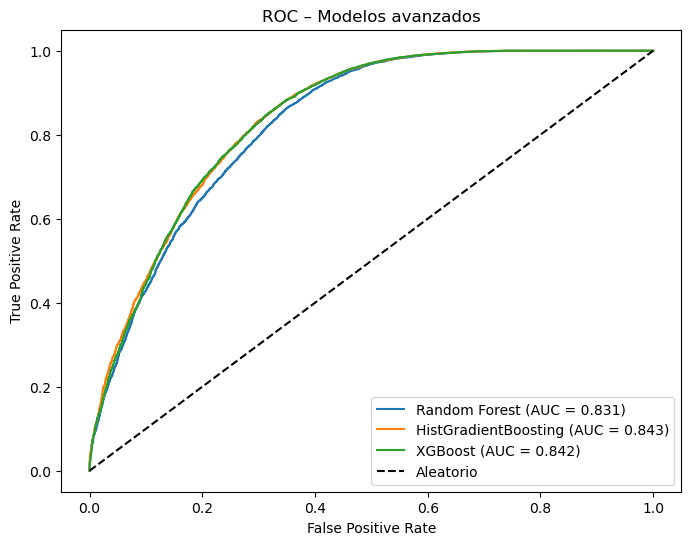

In [20]:
plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_value = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_value:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Aleatorio")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – Modelos avanzados")
plt.legend()
plt.savefig(FIGURES_DIR / "roc_advanced.png", dpi=300, bbox_inches="tight")
plt.show()


In [21]:

thresholds = np.arange(0.1, 0.9, 0.02)

rows = []

for t in thresholds:
    y_pred_adj = (y_proba_sm > t).astype(int)
    
    recall_0 = recall_score(y_test, y_pred_adj, pos_label=0)
    recall_1 = recall_score(y_test, y_pred_adj, pos_label=1)
    
    precision_0 = precision_score(y_test, y_pred_adj, pos_label=0, zero_division=0)
    precision_1 = precision_score(y_test, y_pred_adj, pos_label=1, zero_division=0)
    
    f1 = f1_score(y_test, y_pred_adj)
    acc = accuracy_score(y_test, y_pred_adj)
    
    rows.append({
        "threshold": t,
        "recall_0": recall_0,
        "recall_1": recall_1,
        "precision_0": precision_0,
        "precision_1": precision_1,
        "f1": f1,
        "accuracy": acc
    })

threshold_df = pd.DataFrame(rows)
threshold_df_sorted = threshold_df.sort_values("recall_0", ascending=False)
threshold_df_sorted.head(20)


,threshold,recall_0,recall_1,precision_0,precision_1,f1,accuracy
39,0.88,0.879534,0.474694,0.277547,0.944975,0.631942,0.550249
38,0.86,0.841599,0.562160,0.306057,0.939274,0.703357,0.614311
37,0.84,0.807550,0.639139,0.339268,0.935376,0.759390,0.670569
36,0.82,0.775352,0.701257,0.373241,0.931528,0.800155,0.715085
35,0.80,0.739082,0.753821,0.407884,0.926425,0.831258,0.751071
34,0.78,0.702998,0.798404,0.444483,0.921358,0.855486,0.780598
33,0.76,0.675241,0.836914,0.487183,0.918243,0.875694,0.806741
32,0.74,0.645263,0.870754,0.533915,0.914515,0.892098,0.828671
31,0.72,0.619356,0.893682,0.572039,0.910972,0.902244,0.842485
30,0.70,0.596410,0.910284,0.604010,0.907663,0.908971,0.851706


In [22]:
t = 0.88
y_pred_t = (y_proba_sm > t).astype(int)

print("Recall_0:", recall_score(y_test, y_pred_t, pos_label=0))
print("Recall_1:", recall_score(y_test, y_pred_t, pos_label=1))
print("Accuracy:", accuracy_score(y_test, y_pred_t))
print("F1:", f1_score(y_test, y_pred_t))


Recall_0: 0.8795336787564767
Recall_1: 0.47469429347826086
Accuracy: 0.5502486531288852
F1: 0.631941892999463


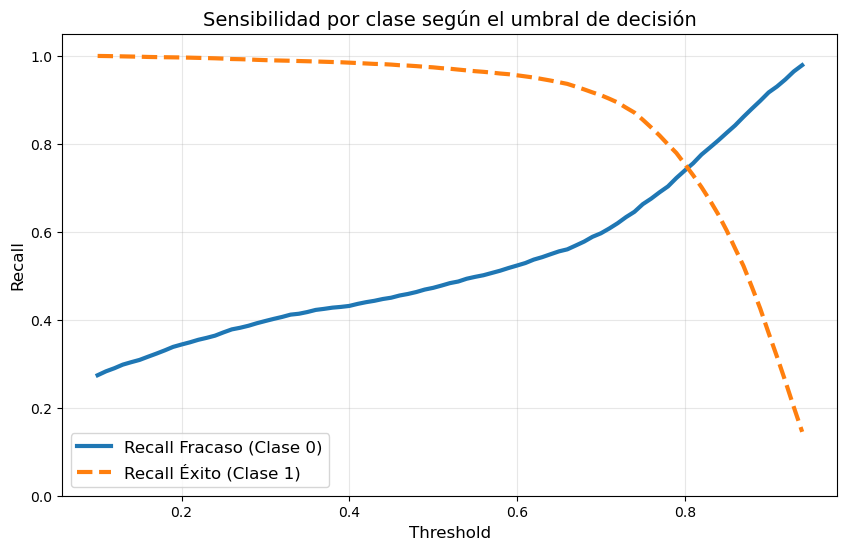

In [23]:


# Probabilidades del modelo entrenado con SMOTE
thresholds = np.arange(0.1, 0.95, 0.01)

recalls_0 = []
recalls_1 = []

for t in thresholds:
    y_pred_t = (y_proba_sm > t).astype(int)
    recalls_0.append(recall_score(y_test, y_pred_t, pos_label=0))
    recalls_1.append(recall_score(y_test, y_pred_t, pos_label=1))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls_0, label="Recall Fracaso (Clase 0)", linewidth=3)
plt.plot(thresholds, recalls_1, label="Recall Éxito (Clase 1)", linewidth=3, linestyle="--")

plt.title("Sensibilidad por clase según el umbral de decisión", fontsize=14)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Recall", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.ylim(0, 1.05)
plt.savefig(FIGURES_DIR / "recall_threshold.png", dpi=300, bbox_inches="tight")


plt.show()


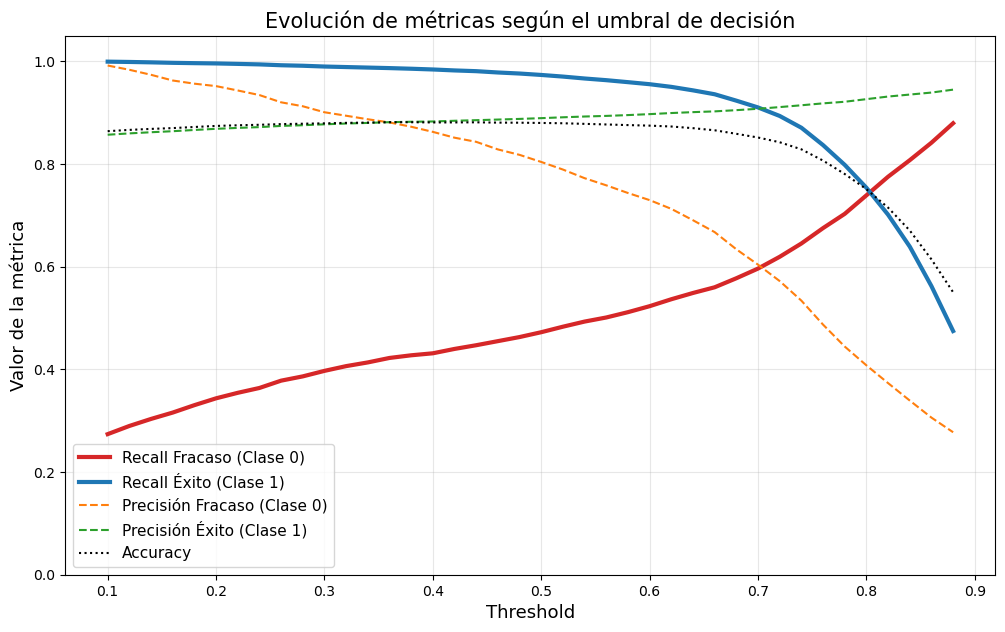

In [24]:
thresholds = np.arange(0.1, 0.9, 0.02)

recall_0_list = []
recall_1_list = []
precision_0_list = []
precision_1_list = []
f1_list = []
accuracy_list = []

for t in thresholds:
    y_pred_adj = (y_proba_sm > t).astype(int)
    
    recall_0_list.append(recall_score(y_test, y_pred_adj, pos_label=0))
    recall_1_list.append(recall_score(y_test, y_pred_adj, pos_label=1))
    
    precision_0_list.append(precision_score(y_test, y_pred_adj, pos_label=0, zero_division=0))
    precision_1_list.append(precision_score(y_test, y_pred_adj, pos_label=1, zero_division=0))

    f1_list.append(f1_score(y_test, y_pred_adj))
    accuracy_list.append(accuracy_score(y_test, y_pred_adj))

plt.figure(figsize=(12, 7))

plt.plot(thresholds, recall_0_list, label="Recall Fracaso (Clase 0)", linewidth=3, color="#d62728")
plt.plot(thresholds, recall_1_list, label="Recall Éxito (Clase 1)", linewidth=3, color="#1f77b4")

plt.plot(thresholds, precision_0_list, label="Precisión Fracaso (Clase 0)", linestyle="--", color="#ff7f0e")
plt.plot(thresholds, precision_1_list, label="Precisión Éxito (Clase 1)", linestyle="--", color="#2ca02c")

plt.plot(thresholds, accuracy_list, label="Accuracy", linestyle=":", color="black")

plt.title("Evolución de métricas según el umbral de decisión", fontsize=15)
plt.xlabel("Threshold", fontsize=13)
plt.ylabel("Valor de la métrica", fontsize=13)
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.ylim(0, 1.05)
plt.savefig(FIGURES_DIR / "metrics_threshold.png", dpi=300, bbox_inches="tight")

plt.show()


In [25]:
tables_dir = PROJECT_ROOT / "reports" / "tables"
tables_dir.mkdir(parents=True, exist_ok=True)

results_df.to_csv(tables_dir / "advanced_status_models.csv", index=False)


In [26]:
# A continuación preparamos la regresión:

# Copiamos el dataset de duración
df_dur = df_duration.copy()

[df_dur.columns]

[Index(['NCTId', 'PrimaryConditionMesh', 'DurationPrimaryDays', 'StartYear',
        'StartMonth', 'StudyFirstSubmitYear', 'LeadSponsorClass_FED',
        'LeadSponsorClass_INDIV', 'LeadSponsorClass_INDUSTRY',
        'LeadSponsorClass_NETWORK', 'LeadSponsorClass_NIH',
        'LeadSponsorClass_OTHER', 'LeadSponsorClass_OTHER_GOV',
        'LeadSponsorClass_UNKNOWN', 'Phase_PHASE1', 'Phase_PHASE1 / PHASE2',
        'Phase_PHASE2', 'Phase_PHASE2 / PHASE3', 'Phase_PHASE3', 'Phase_PHASE4',
        'PrimaryInterventionMesh', 'EnrollmentCount', 'Sex_ALL', 'Sex_FEMALE',
        'Sex_MALE', 'MinAgeYears', 'MaxAgeYears', 'AgeRange', 'IsPediatric',
        'IsElderly', 'IsRandomized', 'IsBlinded', 'SummaryLength',
        'DesignMasking_NONE', 'DesignMasking_QUADRUPLE', 'DesignMasking_SINGLE',
        'DesignMasking_TRIPLE', 'DesignMasking_Unknown',
        'PrimaryCountry_reduced_Canada', 'PrimaryCountry_reduced_China',
        'PrimaryCountry_reduced_Egypt', 'PrimaryCountry_reduced_France',
 

In [27]:


# Variable objetivo: duración primaria en días
y_dur = pd.to_numeric(df_dur["DurationPrimaryDays"].astype(str).str.replace(r"[\[\]]","", regex=True),
                      errors="coerce")

# Quitamos columnas que no queremos usar como predictores:
# - La propia etiqueta (DurationPrimaryDays)
# - Identificador
# - Texto libre
# - Estados del ensayo (para no meter un resultado "final" como feature)
cols_to_drop_dur = [
    "DurationPrimaryDays",
    "NCTId",
    "PrimaryConditionMesh",
    "PrimaryInterventionMesh",
    "OverallStatus_COMPLETED",
    "OverallStatus_TERMINATED",
    "OverallStatus_WITHDRAWN",
    "OverallStatus_SUSPENDED",
    "OverallStatus_ENROLLING_BY_INVITATION",
    "OverallStatus_NOT_YET_RECRUITING",
    "OverallStatus_RECRUITING",
    "OverallStatus_UNKNOWN",
]

# Nos quedamos con el resto de columnas numéricas / dummies
features_dur = [c for c in df_dur.columns if c not in cols_to_drop_dur]
X_dur = df_dur[features_dur]

X_train_dur, X_test_dur, y_train_dur, y_test_dur = train_test_split(
    X_dur, y_dur, test_size=0.2, random_state=42
)

len(features_dur), X_train_dur.shape, X_test_dur.shape

def evaluate_reg(model, X_test, y_test, name):
    """
    Devuelve métricas de regresión en un dict:
    - RMSE
    - MAE
    - R²
    """
    y_pred = model.predict(X_test)
    metrics = {
        "model": name,
        "rmse": mean_squared_error(y_test, y_pred) ** 0.5,  # sin squared=False
        "mae": mean_absolute_error(y_test, y_pred),
        "r2": r2_score(y_test, y_pred),
    }
    return metrics

In [28]:
#2.1 Modelos base avanzados (sin tuning)

# Random Forest Regressor (base)
rf_reg = RandomForestRegressor(
    random_state=42,
    n_estimators=200,
    n_jobs=-1
)
rf_reg.fit(X_train_dur, y_train_dur)
m_rf_base = evaluate_reg(rf_reg, X_test_dur, y_test_dur, "RandomForest (base)")

# HistGradientBoosting Regressor (base)
hgb_reg = HistGradientBoostingRegressor(random_state=42)
hgb_reg.fit(X_train_dur, y_train_dur)
m_hgb_base = evaluate_reg(hgb_reg, X_test_dur, y_test_dur, "HistGB (base)")

# XGBoost Regressor (base)
xgb_reg = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=1.0,
    colsample_bytree=1.0,
    tree_method="hist",
    n_jobs=-1
)
xgb_reg.fit(X_train_dur, y_train_dur)
m_xgb_base = evaluate_reg(xgb_reg, X_test_dur, y_test_dur, "XGBoost (base)")

pd.DataFrame([m_rf_base, m_hgb_base, m_xgb_base])

,model,rmse,mae,r2
0,RandomForest (base),666.522994,455.543036,0.325632
1,HistGB (base),659.995782,453.473191,0.338775
2,XGBoost (base),656.178044,448.184775,0.346403


In [29]:
# 2.2 Tuning ligero de hiperparámetros

# ---------------- Random Forest (tuning) ----------------
param_dist_rf_reg = {
    "n_estimators": [200, 400],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True]
}

rf_reg_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist_rf_reg,
    n_iter=20,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Usamos una muestra del 10% del train para tuning, como en status
X_tuned_dur, _, y_tuned_dur, _ = train_test_split(
    X_train_dur, y_train_dur,
    train_size=0.10,
    random_state=42
)

rf_reg_random.fit(X_tuned_dur, y_tuned_dur)
rf_reg_random.best_params_

rf_reg_best = RandomForestRegressor(
    **rf_reg_random.best_params_,
    random_state=42,
    n_jobs=-1
)
rf_reg_best.fit(X_train_dur, y_train_dur)
m_rf_best = evaluate_reg(rf_reg_best, X_test_dur, y_test_dur, "RandomForest (tuned)")
m_rf_best

# ---------------- HistGradientBoosting (tuning) ----------------
param_dist_hgb_reg = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7, None],
    "min_samples_leaf": [10, 20, 50],
    "l2_regularization": [0.0, 0.1, 1.0]
}

hgb_reg_random = RandomizedSearchCV(
    estimator=HistGradientBoostingRegressor(random_state=42),
    param_distributions=param_dist_hgb_reg,
    n_iter=20,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

hgb_reg_random.fit(X_tuned_dur, y_tuned_dur)
hgb_reg_random.best_params_

hgb_reg_best = hgb_reg_random.best_estimator_
hgb_reg_best.fit(X_train_dur, y_train_dur)
m_hgb_best = evaluate_reg(hgb_reg_best, X_test_dur, y_test_dur, "HistGB (tuned)")
m_hgb_best

# ---------------- XGBoost Regressor (tuning) ----------------
param_dist_xgb_reg = {
    "n_estimators": [200, 400],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.7, 1.0]
}

xgb_reg_random = RandomizedSearchCV(
    estimator=XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    ),
    param_distributions=param_dist_xgb_reg,
    n_iter=15,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

xgb_reg_random.fit(X_tuned_dur, y_tuned_dur)
xgb_reg_random.best_params_

xgb_reg_best = XGBRegressor(
    **xgb_reg_random.best_params_,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)
xgb_reg_best.fit(X_train_dur, y_train_dur)
m_xgb_best = evaluate_reg(xgb_reg_best, X_test_dur, y_test_dur, "XGBoost (tuned)")
m_xgb_best

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits


{'model': 'XGBoost (tuned)',
 'rmse': 663.6617910811318,
 'mae': 455.6347384028693,
 'r2': 0.33140901753377394}

In [30]:

# 2.3 Comparativa final de modelos de duración

results_reg = pd.DataFrame(
    [m_rf_base, m_hgb_base, m_xgb_base, m_rf_best, m_hgb_best, m_xgb_best]
).sort_values("rmse")

results_reg


tables_dir = PROJECT_ROOT / "reports" / "tables"
tables_dir.mkdir(parents=True, exist_ok=True)

results_reg.to_csv(tables_dir / "advanced_duration_models.csv", index=False)

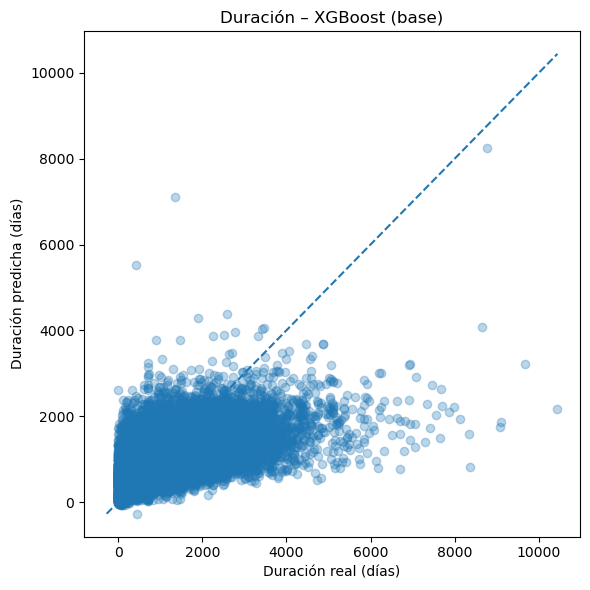

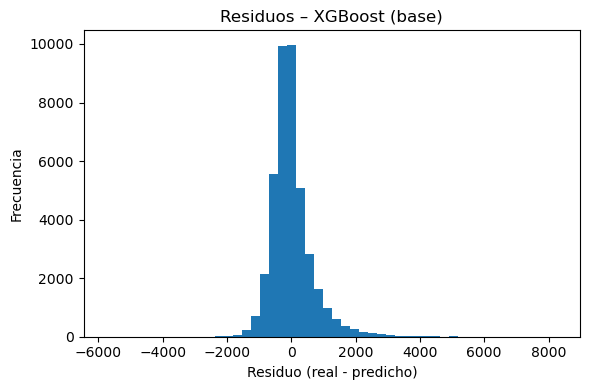

In [31]:
# 2.4 Gráficos: y_real vs y_pred y residuos
#Escogemos el mejor modelo, el de menor RMSE:


best_model_name = results_reg.iloc[0]["model"]
best_model_name

model_map_reg = {
    "RandomForest (base)": rf_reg,
    "HistGB (base)": hgb_reg,
    "XGBoost (base)": xgb_reg,
    "RandomForest (tuned)": rf_reg_best,
    "HistGB (tuned)": hgb_reg_best,
    "XGBoost (tuned)": xgb_reg_best,
}

best_reg_model = model_map_reg[best_model_name]

y_pred_best_reg = best_reg_model.predict(X_test_dur)
#Scatter y_real vs y_pred:


plt.figure(figsize=(6, 6))
plt.scatter(y_test_dur, y_pred_best_reg, alpha=0.3)
min_val = min(y_test_dur.min(), y_pred_best_reg.min())
max_val = max(y_test_dur.max(), y_pred_best_reg.max())
plt.plot([min_val, max_val], [min_val, max_val], "--")

plt.xlabel("Duración real (días)")
plt.ylabel("Duración predicha (días)")
plt.title(f"Duración – {best_model_name}")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "duration_best_scatter.png", dpi=300, bbox_inches="tight")
plt.show()
# Distribución de residuos:


residuals = y_test_dur - y_pred_best_reg

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50)
plt.xlabel("Residuo (real - predicho)")
plt.ylabel("Frecuencia")
plt.title(f"Residuos – {best_model_name}")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "duration_best_residuals.png", dpi=300, bbox_inches="tight")
plt.show()

In [32]:
#2.5 Importancia de variables
#Random Forest:


rf_reg_importances = pd.Series(
    rf_reg_best.feature_importances_,
    index=features_dur
).sort_values(ascending=False)

rf_reg_importances.head(20)

#XGBoost:


booster_reg = xgb_reg_best.get_booster()
importance_dict_reg = booster_reg.get_score(importance_type="gain")

importance_df_reg = pd.DataFrame({
    "Feature": list(importance_dict_reg.keys()),
    "Gain": list(importance_dict_reg.values())
}).sort_values(by="Gain", ascending=False)

importance_df_reg.head(20)

,Feature,Gain
5,LeadSponsorClass_INDUSTRY,274177824.0
42,PrimaryCountry_reduced_United States,130150808.0
28,DesignMasking_NONE,77819584.0
8,LeadSponsorClass_OTHER,67964048.0
10,Phase_PHASE1,58641708.0
15,Phase_PHASE4,44075524.0
26,IsBlinded,43933640.0
25,IsRandomized,38925272.0
16,EnrollmentCount,36552416.0
7,LeadSponsorClass_NIH,29811354.0


In [33]:
# Guardamos los modelos y los X, y

dump(xgb_best, ART_DIR / "xgb_status.joblib")
dump(best_reg_model, ART_DIR / "xgb_dur.joblib")


X_test.to_csv(ART_DIR / "X_test_status.csv", index=False)
y_test.to_frame("target").to_csv(ART_DIR / "y_test_status.csv", index=False)

X_test_dur.to_csv(ART_DIR / "X_test_dur.csv", index=False)
y_test_dur.to_frame("DurationPrimaryDays").to_csv(ART_DIR / "y_test_dur.csv", index=False)
